# **Measuring Bias in clustering**


This notebook is a tutorial on auditing bias within a clustering task. We will use the _holisticai_ library throughout, introducing some of the functions we have created to help study algorithmic bias.

The sections are organised as follows :

1. Load the data : we load the adult dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Pre-Processing and Train a Model : we train a kmeans model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os,sys

dirpath = os.path.join( '/'.join(os.getcwd().split("/")[:-3]), 'src')
sys.path.insert(0, dirpath)

We will start by importing the adult dataset, which we host on our library. The adult dataset contains a set of informations extract from US 1994 Census database. It includes personal information about the individuals, specifically sex, race, and education. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether this clustering contains gender or race information (clustering bias).

In [3]:
from holisticai.datasets import load_dataset
from holisticai.datasets._dataset import load_dataset

dataset = load_dataset('adult')
dataset

Dataset({
        features: ['data', 'x', 'y', 'group_a', 'group_b'],
        num_rows: 45222
    })

## **Data Exploration**

In [4]:
# import holisticai charts
from holisticai.plots.bias import group_pie_plot, histogram_plot
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Histogram Plot')

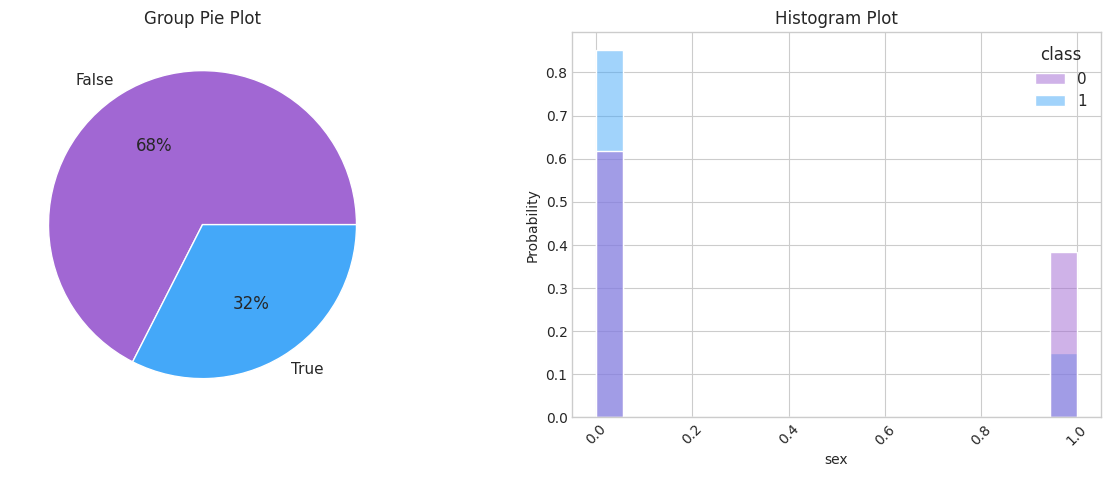

In [5]:
fig,axs = plt.subplots(1,2, figsize=(15,5))
group_pie_plot(dataset['group_a'], ax=axs[0])
histogram_plot(dataset['group_a'], dataset['y'], ax=axs[1])
axs[0].set_title('Group Pie Plot')
axs[1].set_title('Histogram Plot')

## **Preprocess data and Train a model**

In [6]:
datasets = dataset.train_test_split(test_size=0.2)
datasets

DatasetDict({
    train: Dataset({
        features: ['data', 'x', 'y', 'group_a', 'group_b'],
        num_rows: 36177
    }),
    test: Dataset({
        features: ['data', 'x', 'y', 'group_a', 'group_b'],
        num_rows: 9045
    })
})

In [7]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train = datasets['train']['x'].values

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # fit model to samples
    model.fit(X_train)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

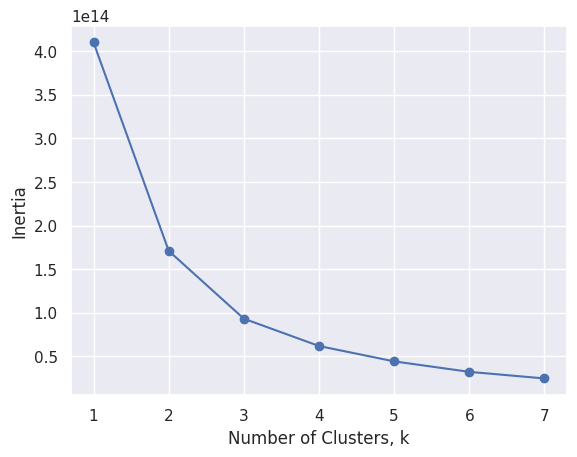

In [8]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [9]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X = datasets['test']['x']
group_a = datasets['test']['group_a']
group_b = datasets['test']['group_b']
# predict
y_pred = model.predict(X)

## **Measure bias**

In [10]:
# imports
from holisticai.plots.bias import frequency_matrix_plot
from holisticai.metrics.bias import cluster_balance

In [11]:
# set up vectors for measuring bias [we consider sex and race]
p_attr_sex = group_a.replace({"Male": 1, "Female": 0})
y_pred = model.predict(X)

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

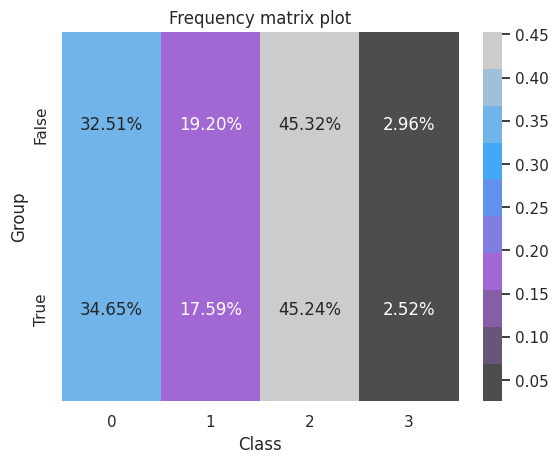

In [12]:
# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='group')

The clustering is quite balanced in terms of gender representations.

In [13]:
cluster_balance(group_a, group_b, y_pred)

0.8948180684988425

The above metric reinforces the clustering is balanced in the sense of each group having similar representation in clusters to overall. The ideal value for this metric is 1.

### Batch computation

In [14]:
from holisticai.metrics.bias import clustering_bias_metrics

In [15]:
centroids = model.cluster_centers_
data = X

In [16]:
y_pred

array([2, 0, 0, ..., 0, 2, 0], dtype=int32)

In [17]:
data.dtypes

age                               float64
fnlwgt                            float64
education-num                     float64
capital-gain                      float64
capital-loss                      float64
                                   ...   
native-country_Thailand             int64
native-country_Trinadad&Tobago      int64
native-country_United-States        int64
native-country_Vietnam              int64
native-country_Yugoslavia           int64
Length: 82, dtype: object

In [18]:
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.894818,1
Minimum Cluster Ratio,0.416667,1
Cluster Distribution Total Variation,0.021353,0
Cluster Distribution KL Div,0.001730,0
Social Fairness Ratio,0.983194,1
Silhouette Difference,0.001816,0


The above metrics hint that the computed clustering **not** biased in terms of sex attribute.